
# Model Building Jupyter Notebook
This Jupyter Notebook serves as the main file for constructing machine learning models and building appropriate feature sets. The notebook is organized into four key sections:

### 1. Data Pre-Processing
In this section, we will ensure the data is adequately processed for model building. We will:

- Assess the current state of data processing.

- Identify any additional features that need to be added to improve model efficiency.
### 2. Model Building
- Here, we will develop the initial models that will be trained on the data processed in the previous section. This section focuses on:

- Constructing the models without fine-tuning or interpretation at this stage.
### 3. Model Training and Evaluation
In this section, we will:

- Train the models using the prepared data.

- Evaluate the performance of each model.

- Determine if the model outputs are reliable and worth further consideration.
### 4. Results
The final section will involve analyzing the decision-making process of the models. We will:

- Examine the results of linear regression models.

- For more advanced algorithms, delve into both local and global interpretations to understand the decision-making of these "black box" models.


#### Setting up Enviornment 

In [23]:
import pandas as pd # This is to read csv files
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc # Classification Evaluation
from sklearn.linear_model import LogisticRegression # Logit Regression
import statsmodels.api as sm # For proper results interpretation of models
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # Different type of scaling

# For LSTM Development 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt # General Plotting
import os 
path = ('P:/6. DSMA/99. Thesis/Github/thesis')
os.chdir(path)

btc = pd.read_csv('data/processed/camel_v3_sol.csv').drop('Unnamed: 0', axis=1)

In [18]:
btc.columns

Index(['Date', 'High', 'Low', 'Close', 'Volume', 'MA_td', '3MA_td', '%K_td',
       '%D_td', 'RSI_td', 'Momentum_td', 'MACD_td', 'CCI_td', 'BB_td',
       'ATR_td', 'TVL', 'PC1', 'PC2', 'PC3', 'PC4', 'WP_PC1', 'WP_PC2',
       'Difference', 'Indicator'],
      dtype='object')

#### Preparing the model dataset

In [24]:
# BTC - Only selecting required columns from the main dataset
btc.index = btc.Date
btc = btc.drop(['Date','Difference','Low','High'], axis=1)

btc = btc.dropna()

In [25]:
btc.Close = btc.Close.pct_change()
btc = btc.dropna()
btc

,Close,Volume,MA_td,3MA_td,%K_td,%D_td,RSI_td,Momentum_td,MACD_td,CCI_td,BB_td,ATR_td,TVL,PC1,PC2,PC3,PC4,WP_PC1,WP_PC2,Indicator
Date,,,,,,,,,,,,,,,,,,,,
2021-03-20,0.000506,68049683,0,0,0,0,0,0,0,0,0,0,-0.035987,0.082233,-0.565135,0.033420,0.226618,0.990978,-0.048688,Hold
2021-03-21,0.008459,64229338,0,0,0,0,0,0,1,0,0,0,0.028738,0.082233,-0.565135,0.033420,0.226618,1.039917,-0.115053,Buy
2021-03-22,0.040963,260995136,0,0,0,0,0,0,1,0,0,0,0.006883,-1.288150,0.338778,-0.066415,0.040599,1.566585,0.047244,Hold
2021-03-23,-0.047888,106780662,0,0,0,0,0,0,0,0,0,0,0.059382,1.476868,1.052318,0.094650,0.364602,1.425824,0.007113,Sell
2021-03-24,-0.038264,118813690,0,0,0,0,0,0,0,0,0,0,-0.036801,0.931739,-0.935702,-0.549775,-0.564407,1.937657,0.030814,Sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-03,-0.084379,2813419415,0,0,0,0,0,1,0,0,0,1,0.024997,-0.742342,-1.335115,0.960264,1.145803,-1.509961,0.298405,Sell
2024-07-04,-0.093658,3243822145,0,0,0,0,0,0,0,0,0,1,-0.064462,-0.740914,0.120943,0.147974,1.178094,-1.533819,0.153005,Hold
2024-07-05,0.053457,4644036182,0,0,1,0,0,0,0,0,0,1,-0.046671,0.217017,-0.994408,0.738295,-0.476535,-1.500987,0.020867,Buy


##### Making lagged variables for non time series models 

In [26]:
variables = [var for var in btc.columns if var != 'Indicator']  # Adjust this if you only want to create lags for specific variables

num_lags = 3

btc_1 = btc.copy()
# Adding n lagged variables for each variable in the DataFrame
for var in variables: # value set to twelce as indepdent variable is the last column out of a total 13
    for lag in range(1, num_lags+1):
        btc_1[f'{var}_lag{lag}'] = btc_1[var].shift(lag)

# Optional: Remove rows with NaN values that result from shifting
btc_1.dropna(inplace=True)

# Replace inf and -inf with NaN
btc_1.replace([np.inf, -np.inf], np.nan, inplace=True)
btc_1.dropna(inplace=True)


btc_1.columns

Index(['Close', 'Volume', 'MA_td', '3MA_td', '%K_td', '%D_td', 'RSI_td',
       'Momentum_td', 'MACD_td', 'CCI_td', 'BB_td', 'ATR_td', 'TVL', 'PC1',
       'PC2', 'PC3', 'PC4', 'WP_PC1', 'WP_PC2', 'Indicator', 'Close_lag1',
       'Close_lag2', 'Close_lag3', 'Volume_lag1', 'Volume_lag2', 'Volume_lag3',
       'MA_td_lag1', 'MA_td_lag2', 'MA_td_lag3', '3MA_td_lag1', '3MA_td_lag2',
       '3MA_td_lag3', '%K_td_lag1', '%K_td_lag2', '%K_td_lag3', '%D_td_lag1',
       '%D_td_lag2', '%D_td_lag3', 'RSI_td_lag1', 'RSI_td_lag2', 'RSI_td_lag3',
       'Momentum_td_lag1', 'Momentum_td_lag2', 'Momentum_td_lag3',
       'MACD_td_lag1', 'MACD_td_lag2', 'MACD_td_lag3', 'CCI_td_lag1',
       'CCI_td_lag2', 'CCI_td_lag3', 'BB_td_lag1', 'BB_td_lag2', 'BB_td_lag3',
       'ATR_td_lag1', 'ATR_td_lag2', 'ATR_td_lag3', 'TVL_lag1', 'TVL_lag2',
       'TVL_lag3', 'PC1_lag1', 'PC1_lag2', 'PC1_lag3', 'PC2_lag1', 'PC2_lag2',
       'PC2_lag3', 'PC3_lag1', 'PC3_lag2', 'PC3_lag3', 'PC4_lag1', 'PC4_lag2',
       'P

##### Initializing Training and Test Datasets

In [27]:
btc_1

,Close,Volume,MA_td,3MA_td,%K_td,%D_td,RSI_td,Momentum_td,MACD_td,CCI_td,...,PC3_lag3,PC4_lag1,PC4_lag2,PC4_lag3,WP_PC1_lag1,WP_PC1_lag2,WP_PC1_lag3,WP_PC2_lag1,WP_PC2_lag2,WP_PC2_lag3
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-23,-0.047888,106780662,0,0,0,0,0,0,0,0,...,0.033420,0.040599,0.226618,0.226618,1.566585,1.039917,0.990978,0.047244,-0.115053,-0.048688
2021-03-24,-0.038264,118813690,0,0,0,0,0,0,0,0,...,0.033420,0.364602,0.040599,0.226618,1.425824,1.566585,1.039917,0.007113,0.047244,-0.115053
2021-03-25,-0.046570,116277943,0,0,0,0,0,0,0,0,...,-0.066415,-0.564407,0.364602,0.040599,1.937657,1.425824,1.566585,0.030814,0.007113,0.047244
2021-03-26,0.134689,149987319,0,0,0,0,0,0,1,0,...,0.094650,-0.795493,-0.564407,0.364602,1.541183,1.937657,1.425824,-0.273406,0.030814,0.007113
2021-03-27,0.116980,223872587,1,0,0,0,0,0,1,0,...,-0.549775,0.010651,-0.795493,-0.564407,1.028571,1.541183,1.937657,-0.090361,-0.273406,0.030814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-03,-0.084379,2813419415,0,0,0,0,0,1,0,0,...,0.030083,-0.570245,0.029707,0.008567,-1.489585,-1.598148,-1.668556,0.209960,0.268466,0.201485
2024-07-04,-0.093658,3243822145,0,0,0,0,0,0,0,0,...,-0.259018,1.145803,-0.570245,0.029707,-1.509961,-1.489585,-1.598148,0.298405,0.209960,0.268466
2024-07-05,0.053457,4644036182,0,0,1,0,0,0,0,0,...,-0.105790,1.178094,1.145803,-0.570245,-1.533819,-1.509961,-1.489585,0.153005,0.298405,0.209960


In [28]:
# Get all column names except 'Tomorrow'
columns = btc_1.drop(columns='Indicator').columns.tolist()

# Select the columns for X
X = btc_1[columns]
y = btc_1['Indicator']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled features back to DataFrame for VIF calculation and to retain column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into training and test sets while respecting the temporal order
split_index = int(len(btc_1) * 0.8)
X_train, X_test = X_scaled_df[:split_index], X_scaled_df[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Convert scaled features back to DataFrame for VIF calculation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
vif["features"] = X_scaled_df.columns

vif.head(5)

,VIF Factor,features
0,3.216038,Close
1,6.040404,Volume
2,3.788105,MA_td
3,3.993838,3MA_td
4,1.998313,%K_td


In [13]:
# Check for inf values
if np.isinf(X).values.any():
    print("There are inf values in the dataset.")

# Check for NaN values
if np.isnan(X).values.any():
    print("There are NaN values in the dataset.")

#### Model 1: RandomForest Regression

In [36]:
from sklearn.ensemble import RandomForestClassifier

rfm = RandomForestClassifier(n_estimators=350,  bootstrap=True, max_depth=15, min_samples_split=5)
rfm.fit(X_train, y_train)
rf_pred = rfm.predict(X_test)

In [37]:
# Evaluate the model
accuracy = accuracy_score(y_test, rf_pred)
conf_matrix = confusion_matrix(y_test, rf_pred)
class_report = classification_report(y_test, rf_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.5020746887966805
Confusion Matrix:
[[  1  69   2]
 [  0 119   2]
 [  0  47   1]]
Classification Report:
              precision    recall  f1-score   support

         Buy       1.00      0.01      0.03        72
        Hold       0.51      0.98      0.67       121
        Sell       0.20      0.02      0.04        48

    accuracy                           0.50       241
   macro avg       0.57      0.34      0.24       241
weighted avg       0.59      0.50      0.35       241



ROC Curve to test model evaluation

###### The ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a classification model. It plots the true positive rate (sensitivity) against the false positive rate (1-specificity) across various threshold settings. The curve illustrates the trade-off between sensitivity and specificity: as one increases, the other may decrease. The area under the curve (AUC) provides a single scalar value to summarize the model's ability to distinguish between the positive and negative classes, with an AUC of 1 indicating perfect classification and an AUC of 0.5 suggesting no better than random chance. Thus, the ROC curve and AUC are valuable tools for assessing and comparing the discriminatory power of different classifiers.

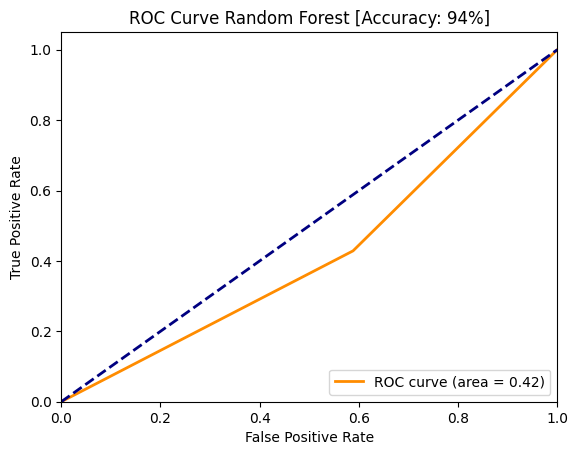

In [17]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, rf_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest [Accuracy: 94%]')
plt.legend(loc="lower right")
plt.show()

#### Model 2: Support Vector Machine (SVM)

In [40]:
from sklearn.svm import SVC

model = SVC(kernel='sigmoid', C = 7, probability=True, gamma='auto')
model.fit(X_train, y_train)

svm_pred = model.predict(X_test)

In [41]:
# Evaluate the model
accuracy = accuracy_score(y_test, svm_pred)
conf_matrix = confusion_matrix(y_test, svm_pred)
class_report = classification_report(y_test, svm_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.3651452282157676
Confusion Matrix:
[[16 29 27]
 [14 42 65]
 [ 6 12 30]]
Classification Report:
              precision    recall  f1-score   support

         Buy       0.44      0.22      0.30        72
        Hold       0.51      0.35      0.41       121
        Sell       0.25      0.62      0.35        48

    accuracy                           0.37       241
   macro avg       0.40      0.40      0.35       241
weighted avg       0.44      0.37      0.37       241



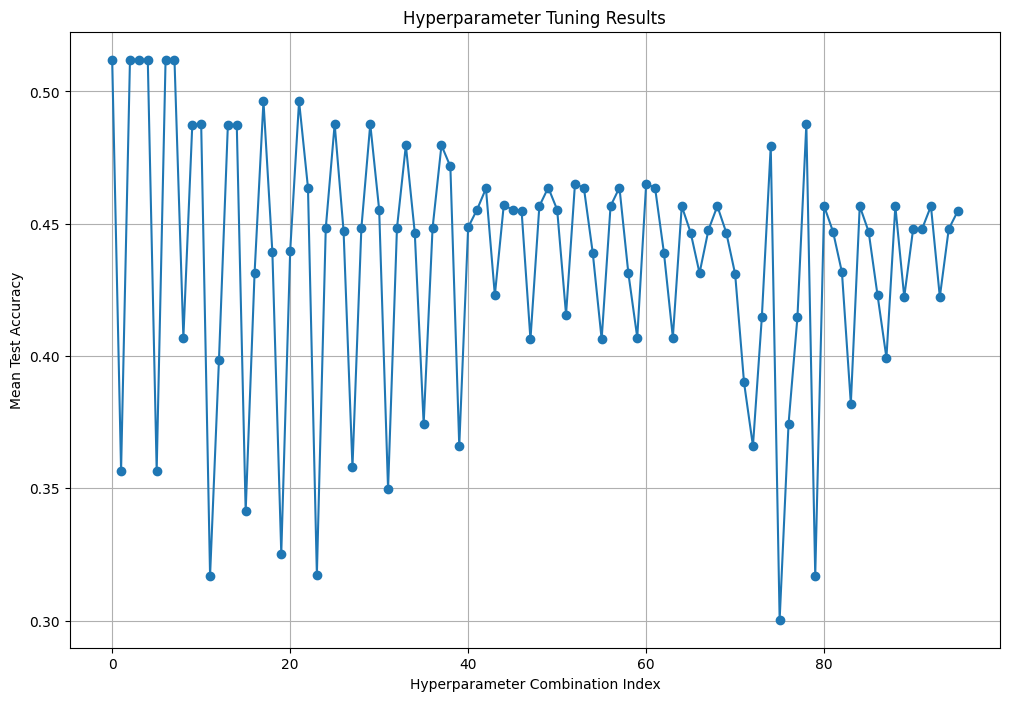

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.5120
Test Accuracy: 0.4516


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'C': [0.1, 2,3,4,5,6,7,8,9, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVC model
svc = SVC(probability=True)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with training data
grid_search.fit(X_train, y_train)

# Get the results of the grid search
results = grid_search.cv_results_

# Extract relevant information
mean_test_scores = results['mean_test_score']
params = results['params']

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(len(mean_test_scores)), mean_test_scores, marker='o')
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Test Accuracy')
plt.grid(True)
plt.show()

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

# Use the best model to make predictions
best_model = grid_search.best_estimator_
svm_pred = best_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, svm_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


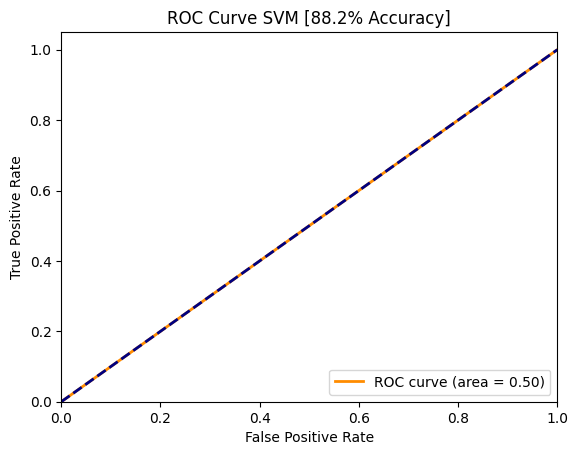

In [21]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, svm_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM [88.2% Accuracy]')
plt.legend(loc="lower right")
plt.show()

In [22]:
import shap 

# Create and fit the explainer
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 32it [00:10,  2.72s/it]                        


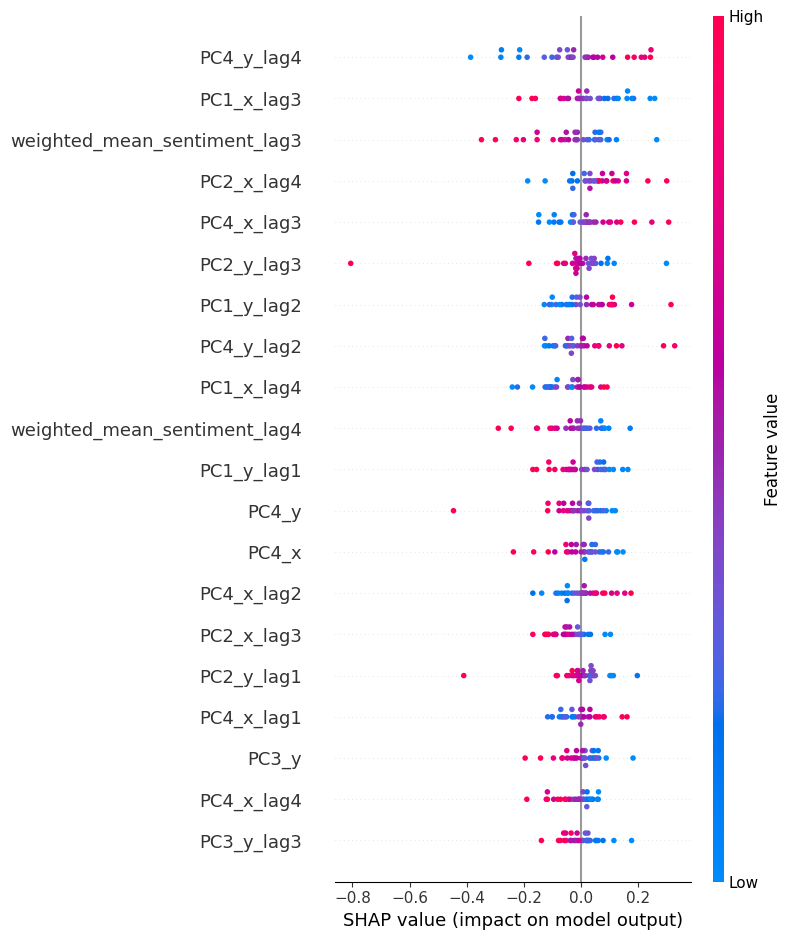

In [23]:
 shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())

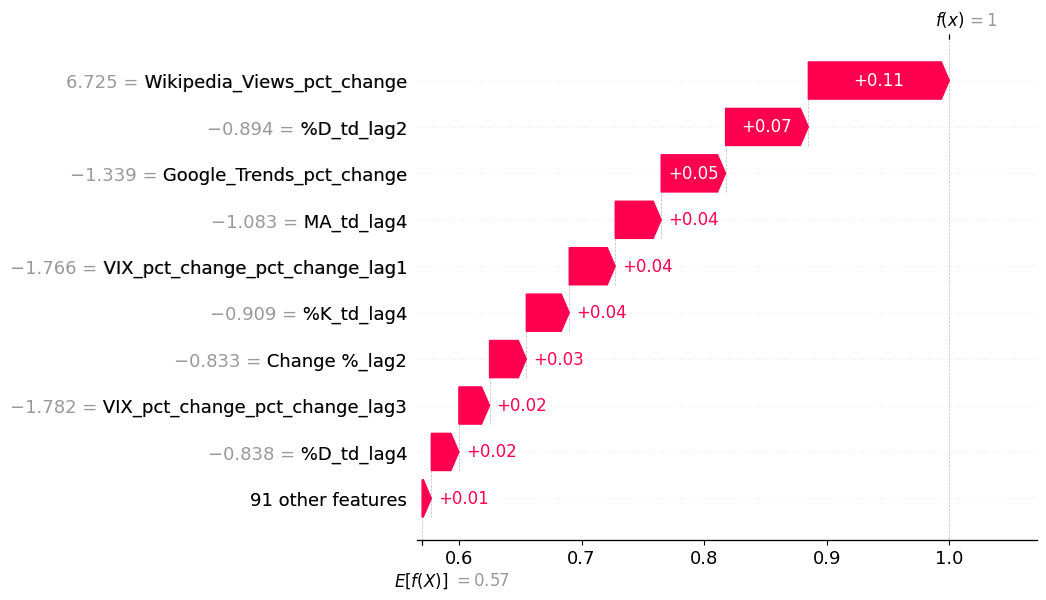

The actual value for the 12th instance is: 1


In [29]:
shap.waterfall_plot(shap_values[12])

# Show the plot
plt.show()

# Fetch the actual value for the 12th instance from y_test
actual_value = y_test.iloc[12]  # Assuming y_test is a DataFrame or Series

print(f"The actual value for the 12th instance is: {actual_value}")

#### Model 3: GradientBoosting

In [42]:
import xgboost as xgb

# Create the DMatrix data format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 10,                  # Maximum depth of a tree
    'eta': 0.1,                      # Learning rate
    'eval_metric': 'logloss'         # Evaluation metric
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Predict the labels of the test set
y_pred_prob = bst.predict(dtest)
xg_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, xg_pred)
conf_matrix = confusion_matrix(y_test, xg_pred)
class_report = classification_report(y_test, xg_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

ValueError: could not convert string to float: 'Sell'

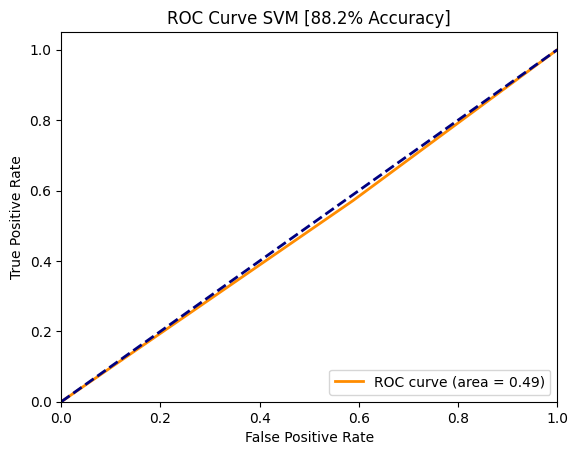

In [26]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, xg_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM [88.2% Accuracy]')
plt.legend(loc="lower right")
plt.show()

#### Model 4: Long Short Term Memory (LSTM)

In [47]:
btc.index = pd.to_datetime(btc.index)
btc_lstm = btc.sort_index()
btc_lstm['Indicator'] = btc_lstm['Indicator'].apply(lambda x: 0 if x == 'Hold' else 1 if x == 'Buy' else -1)

btc_lstm.replace([np.inf, -np.inf], np.nan, inplace=True)
btc_lstm.dropna(inplace=True)


# Get all column names except 'Tomorrow'
columns = btc_lstm.drop(columns='Indicator').columns.tolist()

# Normalize the feature columns
feature_scaler = MinMaxScaler()
btc_lstm[columns] = feature_scaler.fit_transform(btc_lstm[columns])

# Normalize the target column separately
target_scaler = MinMaxScaler()
btc_lstm['Indicator'] = target_scaler.fit_transform(btc_lstm['Indicator'].values.reshape(-1, 1))
# Function to create sequences
def create_sequences(data, target, past_days):
    sequences = []
    labels = []
    for i in range(past_days, len(data)):
        sequences.append(data[i-past_days:i])
        labels.append(target[i])
    return np.array(sequences), np.array(labels)

# Extract the feature columns and the target column
feature_data = btc_lstm[columns].values
target_data = btc_lstm['Indicator'].values

# Create sequences with 3 past days
past_days = 21
X, y = create_sequences(feature_data, target_data, past_days)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(columns)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(columns)))

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

# Assuming btc is your DataFrame
btc.index = pd.to_datetime(btc.index)
btc_lstm = btc.sort_index()

# Convert 'Indicator' to numeric classes
btc_lstm['Indicator'] = btc_lstm['Indicator'].map({'Hold': 0, 'Buy': 1, 'Sell': 2})

btc_lstm.replace([np.inf, -np.inf], np.nan, inplace=True)
btc_lstm.dropna(inplace=True)

# Get all column names except 'Indicator'
columns = btc_lstm.drop(columns='Indicator').columns.tolist()

# Normalize the feature columns
feature_scaler = MinMaxScaler()
btc_lstm[columns] = feature_scaler.fit_transform(btc_lstm[columns])

# Function to create sequences
def create_sequences(data, target, past_days):
    sequences = []
    labels = []
    for i in range(past_days, len(data)):
        sequences.append(data[i-past_days:i])
        labels.append(target[i])
    return np.array(sequences), np.array(labels)

# Extract the feature columns and the target column
feature_data = btc_lstm[columns].values
target_data = btc_lstm['Indicator'].values

# Create sequences with 21 past days
past_days = 21
X, y = create_sequences(feature_data, target_data, past_days)

# Convert the target to one-hot encoded format
y = to_categorical(y, num_classes=3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(columns)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(columns)))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (948, 21, 19)
y_train shape: (948, 3)
X_test shape: (237, 21, 19)
y_test shape: (237, 3)


In [49]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=(past_days, len(columns))))
model.add(LSTM(40, return_sequences=True))
model.add(LSTM(40))
model.add(Dense(3))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
# Fit the model
model.fit(X_train, y_train, epochs=120, batch_size=12, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions_lstm = model.predict(X_test)
predictions_lstm = target_scaler.inverse_transform(predictions_lstm)
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))

print('Predicted vs Actual form the model')
print('')
# Display the first 10 predictions and actual values
for i in range(10):
    print(f'Predicted: {predictions_lstm[i][0]}, Actual: {y_test[i][0]}')

# Evaluate the model

binary_predictions = (predictions_lstm > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_predictions)
conf_matrix = confusion_matrix(y_test, binary_predictions)
class_report = classification_report(y_test, binary_predictions)
print('')
print('')
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Epoch 1/120

79/79 [==============================] - 3s 15ms/step - loss: 0.1335 - val_loss: 0.1193
Epoch 2/120
79/79 [==============================] - 1s 7ms/step - loss: 0.1223 - val_loss: 0.1232
Epoch 3/120
79/79 [==============================] - 1s 7ms/step - loss: 0.1231 - val_loss: 0.1221
Epoch 4/120
79/79 [==============================] - 1s 7ms/step - loss: 0.1240 - val_loss: 0.1185
Epoch 5/120
79/79 [==============================] - 1s 7ms/step - loss: 0.1236 - val_loss: 0.1193
Epoch 6/120
79/79 [==============================] - 1s 7ms/step - loss: 0.1221 - val_loss: 0.1182
Epoch 7/120
79/79 [==============================] - 1s 7ms/step - loss: 0.1235 - val_loss: 0.1183
Epoch 8/120
79/79 [==============================] - 1s 8ms/step - loss: 0.1224 - val_loss: 0.1190
Epoch 9/120
79/79 [==============================] - 1s 8ms/step - loss: 0.1226 - val_loss: 0.1189
Epoch 10/120
79/79 [==============================] - 1s 8ms/step - loss: 0.1215 - val_loss: 0.1187
Epoch 1

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

Epoch 1/30
48/48 [==============================] - 4s 27ms/step - loss: 1.0537 - accuracy: 0.4768 - val_loss: 1.0397 - val_accuracy: 0.5274
Epoch 2/30
48/48 [==============================] - 1s 11ms/step - loss: 1.0400 - accuracy: 0.5137 - val_loss: 1.0243 - val_accuracy: 0.5274
Epoch 3/30
48/48 [==============================] - 0s 10ms/step - loss: 1.0361 - accuracy: 0.5137 - val_loss: 1.0240 - val_accuracy: 0.5274
Epoch 4/30
48/48 [==============================] - 0s 10ms/step - loss: 1.0341 - accuracy: 0.5137 - val_loss: 1.0216 - val_accuracy: 0.5274
Epoch 5/30
48/48 [==============================] - 1s 11ms/step - loss: 1.0359 - accuracy: 0.5137 - val_loss: 1.0225 - val_accuracy: 0.5274
Epoch 6/30
48/48 [==============================] - 0s 10ms/step - loss: 1.0292 - accuracy: 0.5137 - val_loss: 1.0256 - val_accuracy: 0.5274
Epoch 7/30
48/48 [==============================] - 0s 10ms/step - loss: 1.0379 - accuracy: 0.5137 - val_loss: 1.0245 - val_accuracy: 0.5274
Epoch 8/30
48

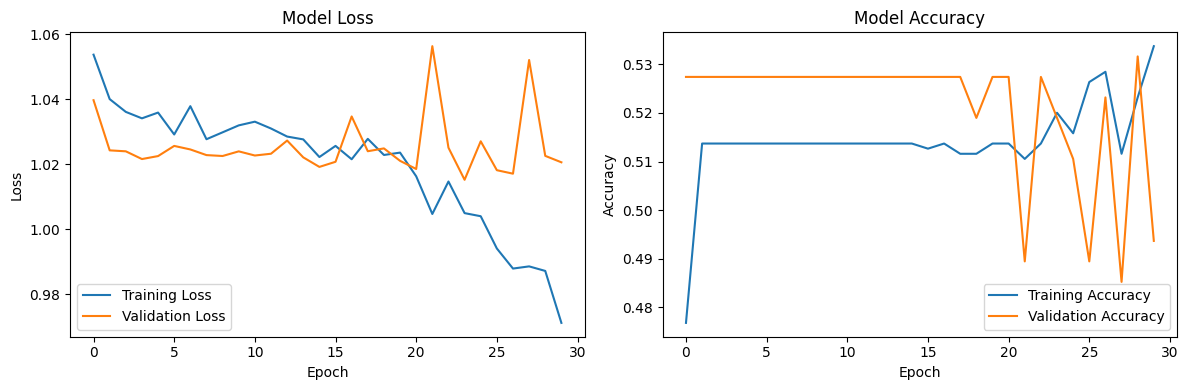

In [51]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the model
model = Sequential([
    LSTM(120, input_shape=(past_days, len(columns)), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=30, batch_size=20, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions
predictions_lstm = model.predict(X_test)

print('Predicted vs Actual from the model')
print('')
# Display the first 10 predictions and actual values
for i in range(10):
    predicted_class = np.argmax(predictions_lstm[i])
    actual_class = np.argmax(y_test[i])
    print(f'Predicted: {predicted_class}, Actual: {actual_class}')

# Convert predictions and actual values to class labels
y_pred = np.argmax(predictions_lstm, axis=1)
y_true = np.argmax(y_test, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=['Hold', 'Buy', 'Sell'])

print('')
print('')
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Optionally, plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, binary_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LSTM [Accuracy: 67%]')
plt.legend(loc="lower right")
plt.show()

ValueError: multiclass format is not supported

In [82]:
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import numpy as np

# Function to get the gradients of the model's output with respect to the input
def get_saliency_map(model, input_data, target_index):
    input_data = tf.convert_to_tensor(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        prediction = model(input_data)
        loss = prediction[:, target_index]
    gradient = tape.gradient(loss, input_data)
    return gradient

# Get a single input sample to compute the saliency map
input_sample = X_test[7:8]

# Compute the saliency map for the sample
saliency_map = get_saliency_map(model, input_sample, 0).numpy().squeeze()


In [83]:
saliency = pd.DataFrame(saliency_map, columns=columns)
saliency = saliency.transpose()
saliency = saliency.sort_values(by=0, ascending=False)
saliency = saliency[:5]
saliency

,0,1,2
%K_td,0.758363,0.458554,-0.096269
%D_td,0.592706,-0.080021,-0.117083
Wikipedia_Views_pct_change,0.528264,-0.491744,-0.804887
VIX_pct_change,0.415895,-0.113845,0.236680
weighted_sentiment_pct_change,0.407681,0.516334,0.125274


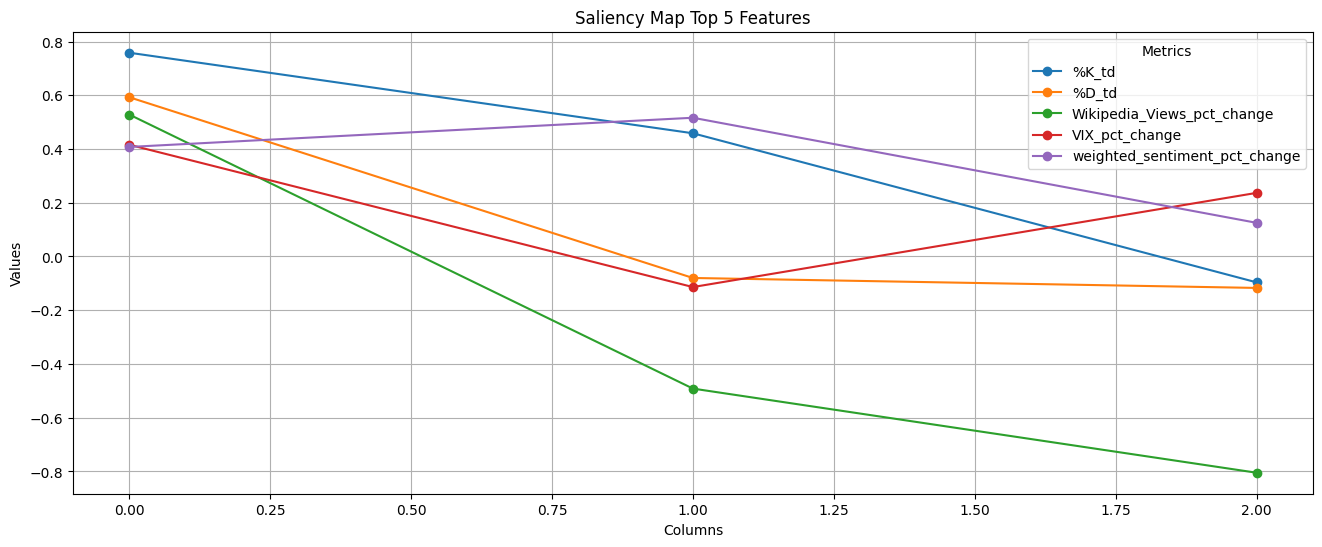

In [84]:
# Plot each row as a separate line chart
plt.figure(figsize=(16, 6))
for row in saliency.index:
    plt.plot(saliency.columns, saliency.loc[row], marker='o', label=row)
plt.title('Saliency Map Top 5 Features')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.legend(title='Metrics')
plt.grid(True)
plt.show()

#### Model 5: Recurrent Neural Network (RNN)

### Aggregations

In [61]:
rf_pred
svm_pred
xg_pred


stacked_predictions = np.vstack([rf_pred, svm_pred, xg_pred])
average_predictions = np.mean(stacked_predictions, axis=0)

# Convert average predictions to binary (0 or 1)
ensemble_predictions = (average_predictions > 0.5).astype(int)

ensemble_predictions.tolist()

ensemble_predictions

# Evaluate the model
accuracy = accuracy_score(y_test, ensemble_predictions)
conf_matrix = confusion_matrix(y_test, ensemble_predictions)
class_report = classification_report(y_test, ensemble_predictions)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.46153846153846156
Confusion Matrix:
[[8 8]
 [6 4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.50      0.53        16
           1       0.33      0.40      0.36        10

    accuracy                           0.46        26
   macro avg       0.45      0.45      0.45        26
weighted avg       0.48      0.46      0.47        26

